In [1]:
from pyabc import History
from pyabc.visualization import plot_kde_matrix
import pyabc.visualization
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import random

try:
    from pyabc.visualization import kde_1d
except:
    from pyabc.visualization.kde import kde_1d  # location for newer versions of pyabc

from tools.DataSimulator import simulate, simulate_all_dates
from tools.DataSimulatorPredict import simulate_all_dates_p

### Load the study data

In [2]:
# Read the study data on adults into a dictionary
study_data_path = os.path.abspath('data/bee_counts/data_adults_eggs.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
    
# Read the full data set for plots/comparison with model output
study_data_all_path = os.path.abspath('data/bee_counts/data_all.csv')
reader = csv.reader(open(study_data_all_path, 'r'))
study_data_all = {}
for row in reader:
   k, v = row
   study_data_all[k] = float(v)

In [3]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0, 100), 
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0,100),
              AILarvaSlope=(1, 9))

### Load the completed AMC-SMC run

In [4]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           #os.path.join(database_dir, "run_3_11.db"))
           os.path.join(database_dir, "run_1_9.db"))
history = History(db_path)
history.id = 1

### Show posterior for last generation

In [5]:
t = history.max_t
df, w = history.get_distribution(m=0, t=t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000

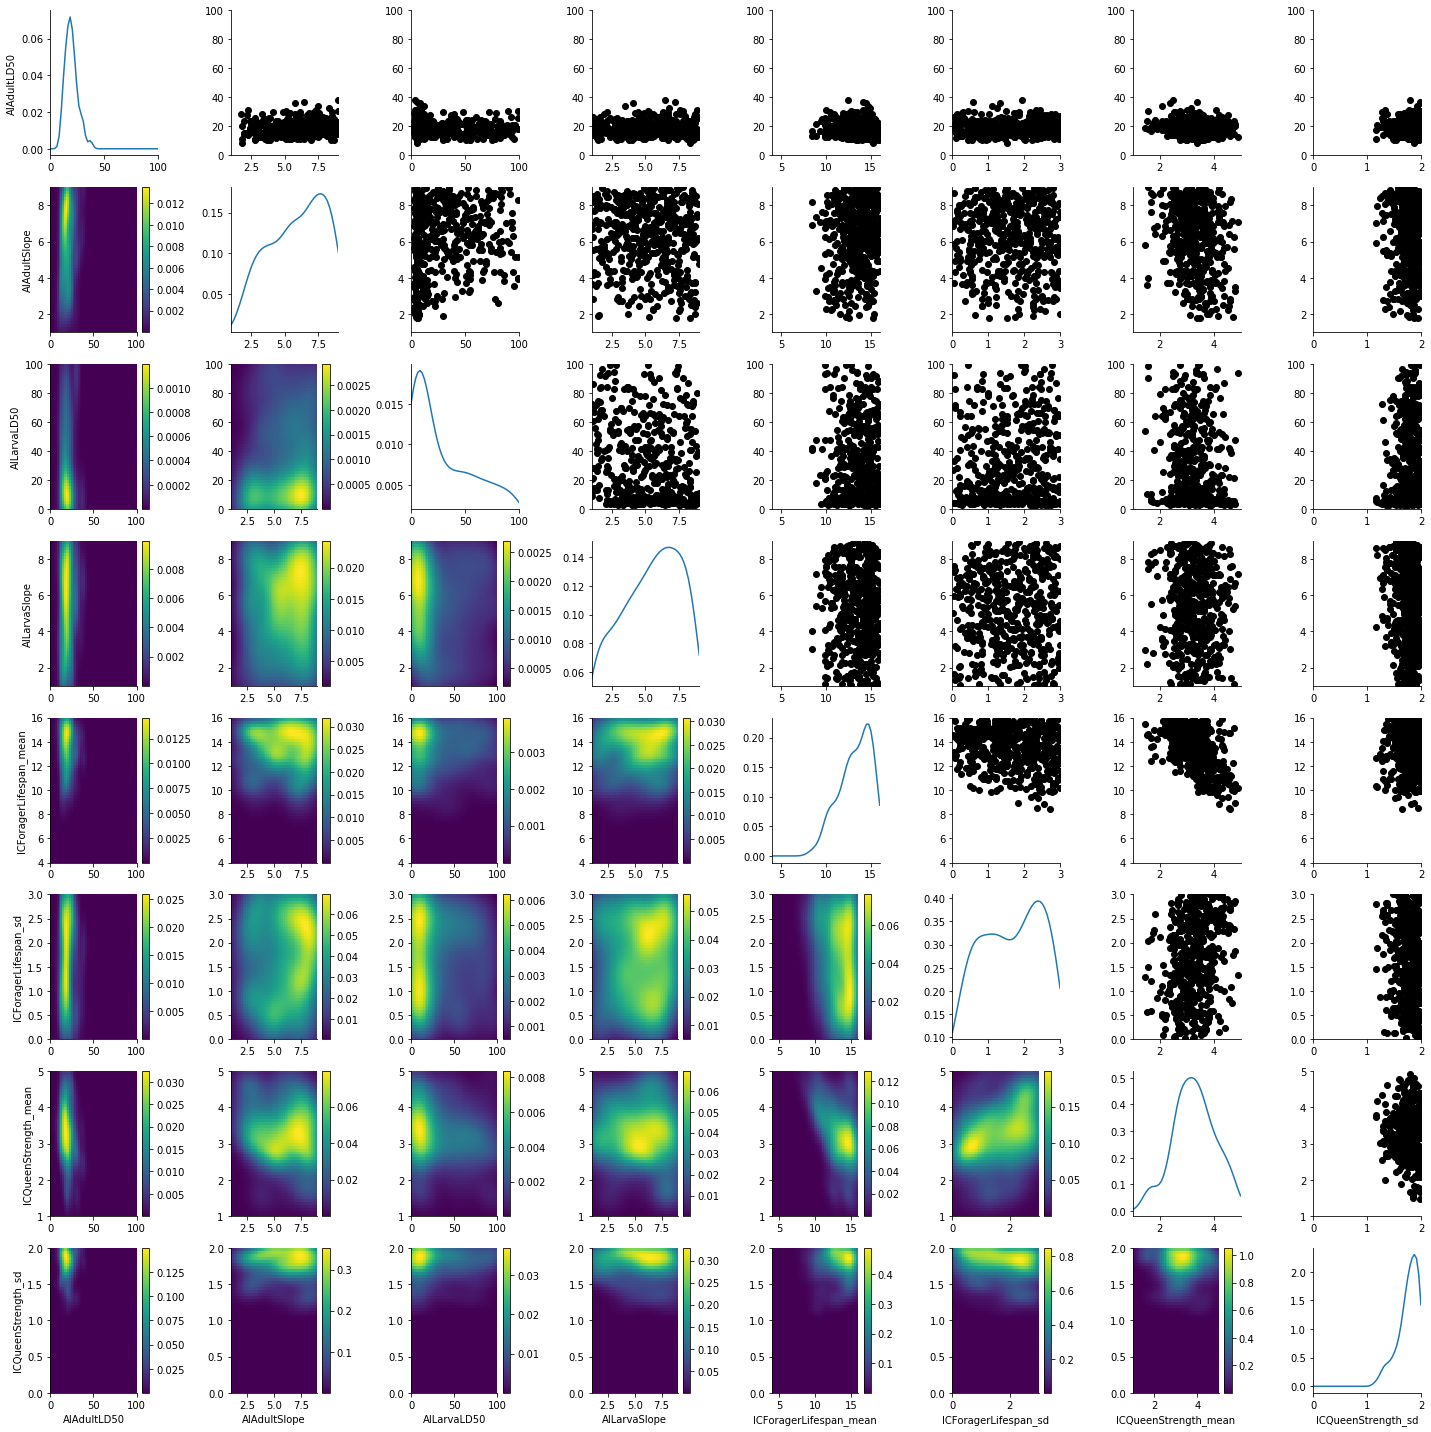

In [6]:
plot_kde_matrix(df, w, limits=limits);

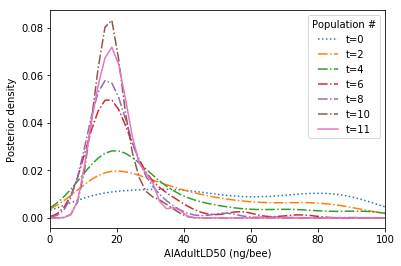

In [12]:
variable = 'AIAdultLD50'
fig, ax = plt.subplots()
for t in list(range(0,history.max_t+1,2))+[history.max_t]:
    df_, w_ = history.get_distribution(m=0, t=t)
    df_["AIAdultLD50"] = df_["AIAdultLD50"].copy() *1000
    ls = "-."
    if t == 0:
        ls=":"
    elif t == history.max_t:
        ls="-"
    pyabc.visualization.plot_kde_1d(df_, w_, xmin=0.1, xmax=100,
                                   x=variable, ax=ax,
                                   label="t={}".format(t), linestyle=ls)
x, pdf = kde_1d(df_,w_,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
#plt.axvline(x=MAP.item(),color='black')
ax.legend(title="Population #")
plt.ylabel('Posterior density')
plt.xlabel('AIAdultLD50 (ng/bee)')
#ax.annotate('Max: {:.2f} ng/bee'.format(MAP.item()), xy = (0.05,0.75))
#fig.patch.set_alpha(0.0)  # use to make area outside plot transparent
plt.savefig('figures/run3_adult_LD50_pops.png',dpi=600)
plt.show()

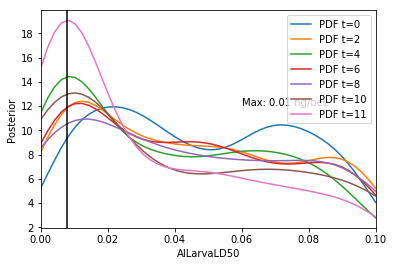

In [13]:
variable = 'AILarvaLD50'
fig, ax = plt.subplots()
for t in list(range(0,history.max_t+1,2))+[history.max_t]:
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0.0001, xmax=0.1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
ax.annotate('Max: {:.2f} ng/bee'.format(MAP.item()), xy = (0.06,12))
plt.show()

### Calculate LD50 max a posteriori estimate and  95% PIs

In [14]:
#get the maximum a posteriori estimation for AdultLD50
df, w = history.get_distribution(m=0, t=history.max_t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
adult_ld50_map = (MAP.item()) 

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
adult_ld50_median = (x.item(np.min(np.where(cdf > .5)))) 
print('Adult LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(adult_ld50_map, adult_ld50_median))

# calculate 95% credible interval
adult_ld50_lower = (x.item(np.min(np.where(cdf > .025))))
adult_ld50_upper = (x.item(np.min(np.where(cdf > .975))))
print("95% CI: {:.2f} - {:.2f}".format(adult_ld50_lower, adult_ld50_upper))
print("")

#get the maximum a posteriori estimation for LarvaLD50
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
larva_ld50_map = (MAP.item()) 

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
larva_ld50_median = (x.item(np.min(np.where(cdf > .5))))
print('Larva LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(larva_ld50_map, larva_ld50_median))

# calculate 95% credible interval
larva_ld50_lower = (x.item(np.min(np.where(cdf > .025))))
larva_ld50_upper = (x.item(np.min(np.where(cdf > .975))))
print("95% CI: {:.2f} - {:.2f}".format(larva_ld50_lower, larva_ld50_upper))

Adult LD50 MAP: 18.28 ng/bee, median: 18.88 ng/bee
95% CI: 10.11 - 32.55

Larva LD50 MAP: 7.84 ng/bee, median: 29.31 ng/bee
95% CI: 3.45 - 93.72


In [8]:
## Define convenience functions for characterizing marginal distributions

def get_ci(variable, df, w, interval = 95):
    """
    Extract 95% credible intervals for a single parameter weighted posterior samples
    """
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    lower = (x.item(np.min(np.where(cdf > .025))))
    upper = (x.item(np.min(np.where(cdf > .975))))
    return lower, upper

def get_MAP(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    MAP = x[np.where(np.max(pdf)==pdf)]
    return MAP.item()

def get_mean(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    mean = np.average(x, weights=pdf)
    return mean

def get_sd(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    sd = np.sqrt(np.cov(x, aweights=pdf))
    return sd
    
def get_median(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    median = (x.item(np.min(np.where(cdf > .5))))
    return median

def describe_marginal(variable, df, w, units = None):
    lower, upper = get_ci(variable, df, w)
    sd = get_sd(variable, df, w)
    MAP = get_MAP(variable, df, w)
    mean = get_mean(variable, df, w)
    median = get_median(variable, df, w)
    unit_str = ""
    if units:
        unit_str = units
    print("Descriptive statistics for {}:".format(variable))
    print("Mean: {:.2f} {}".format(mean, unit_str))
    print("SD: {:.2f} {}".format(sd, unit_str))
    print("Median {:.2f} {}".format(median, unit_str))
    print("MAP: {:.2f} {}".format(MAP, unit_str))
    print("95% CI: {:.2f} - {:.2f} {}".format(lower, upper, unit_str))
    

In [17]:
describe_marginal("AIAdultLD50", df, w, units = "ng/bee")
print()
describe_marginal("AIAdultSlope", df, w)
print()
describe_marginal("AILarvaLD50", df, w, units = "ng/bee")
print()
describe_marginal("AILarvaSlope", df, w)
print()
describe_marginal("ICQueenStrength_mean", df, w)
print()
describe_marginal("ICQueenStrength_sd", df, w)
print()
describe_marginal("ICForagerLifespan_mean", df, w, units = "days")
print()
describe_marginal("ICForagerLifespan_sd", df, w, units = "days")


Descriptive statistics for AIAdultLD50:
Mean: 19.54 ng/bee
SD: 5.81 ng/bee
Median 18.88 ng/bee
MAP: 18.28 ng/bee
95% CI: 10.11 - 32.55 ng/bee

Descriptive statistics for AIAdultSlope:
Mean: 5.84 
SD: 1.95 
Median 6.06 
MAP: 7.66 
95% CI: 2.19 - 8.82 

Descriptive statistics for AILarvaLD50:
Mean: 37.06 ng/bee
SD: 27.63 ng/bee
Median 29.31 ng/bee
MAP: 7.84 ng/bee
95% CI: 3.45 - 93.72 ng/bee

Descriptive statistics for AILarvaSlope:
Mean: 5.33 
SD: 2.13 
Median 5.53 
MAP: 6.73 
95% CI: 1.39 - 8.72 

Descriptive statistics for ICQueenStrength_mean:
Mean: 3.28 
SD: 0.75 
Median 3.26 
MAP: 3.17 
95% CI: 1.75 - 4.72 

Descriptive statistics for ICQueenStrength_sd:
Mean: 1.74 
SD: 0.19 
Median 1.78 
MAP: 1.88 
95% CI: 1.28 - 1.99 

Descriptive statistics for ICForagerLifespan_mean:
Mean: 13.19 days
SD: 1.75 days
Median 13.45 days
MAP: 14.66 days
95% CI: 9.51 - 15.76 days

Descriptive statistics for ICForagerLifespan_sd:
Mean: 1.61 days
SD: 0.82 days
Median 1.65 days
MAP: 2.38 days
95% CI: 0.1

### Draw from posterior to predict dose-response curve for adults

We can draw from our last generation of particles, with probabilty proportional to their weights, to sample the posterior.
Draws of ld50 and slope can be combined to plot dose-response curves.

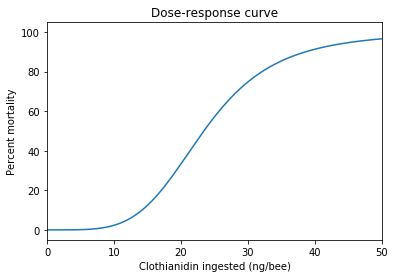

In [6]:
def draw_posterior(df, w, n=1):
    indices = df.index
    draws = random.choices(population=indices, weights = w, k=n)
    return df.loc[draws,:]

def plot_dose_response(ld50, slope, xlim=100, max_dose=100, title='Dose-response curve' ):
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50/x)**slope) #four parameters Hill equation, equal to what VarroaPop uses
    fix, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    plt.show()

df, w = history.get_distribution(m=0, t=history.max_t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
random.seed(1251)
sample = draw_posterior(df, w, 1)

#Plot a single curve
sample_ld50 = sample.iloc[0,0]
sample_slope = sample.iloc[0,1]
#print("LD50: {}, Slope: {}".format(sample_ld50, sample_slope))
plot_dose_response(sample_ld50, sample_slope, xlim=50)

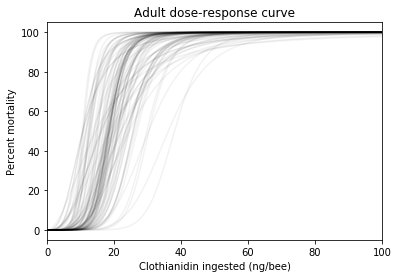

In [7]:
### Plot many curves together

def plot_all_dr(sample, xlim=100, max_dose=100, adult=True, title='Dose-response curve',):
    fix, ax = plt.subplots()
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    ld50_col, slope_col = 0, 1
    if not adult:
        ld50_col, slope_col = ld50_col+2, slope_col+2
    for index, row in sample.iterrows():
        ld50 = row[ld50_col]
        slope = row[slope_col]
        y = 100/(1+(ld50/x)**slope) #four parameters Hill equation
        ax.plot(x, y, 'k',alpha=0.05)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    plt.show()

df, w = history.get_distribution(m=0, t=history.max_t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
random.seed(1251)
sample = draw_posterior(df, w, 100)

plot_all_dr(sample, xlim=100, title="Adult dose-response curve")

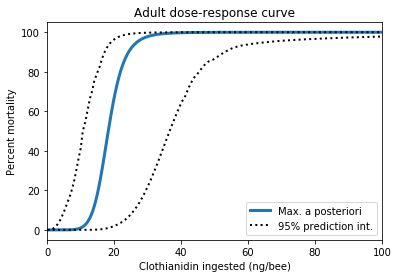

In [8]:
### Plot MAP and 95% Prediction interval

def get_prediction_interval(sample_in, percent=95, max_dose=100, adult=True):
    """
    Get PIs for dose-response curve. 
    Function that takes a set of samples of the posterior (as a input) and returns
    the lower and upper perdiction intervals as 1d arrays.
    """
    sample = sample_in.reset_index(drop=True)
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = np.empty([len(sample.index),x.size])
    if adult:
        for index, row in sample.iterrows():
            ld50 = row[0]
            slope = row[1]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    else:
        for index, row in sample.iterrows():
            ld50 = row[2]
            slope = row[3]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    lower = np.percentile(y,q=(100-percent)/2, axis=0)
    upper = np.percentile(y, q=100-((100-percent)/2), axis=0)
    return lower, upper


def plot_dr_map(df, adult=True, xlim=100, ci=True, percent = 95, sample_num=500, title="Dose-response curve", save = False, filename='adult_dr_map'):
    """
    Plot the dose-response curve for a posterior based on maximum a posteriori values.
    Can also include prediction intervals, which are based on weighted random sampling of the particles. 
    """
    if adult:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AIAdultLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AIAdultSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    else:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AILarvaLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AILarvaSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    sample = draw_posterior(df, w, sample_num)
    lower, upper = get_prediction_interval(sample, max_dose=xlim, adult=adult)
    fix, ax = plt.subplots()
    x = np.linspace(0,xlim, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50_MAP/x)**slope_MAP) #four parameters Hill equation, equal to what VarroaPop uses
    ax.plot(x, y, linewidth=3, label="Max. a posteriori")
    ax.plot(x,lower, 'k', linestyle=":", linewidth=2, label="95% prediction int.")
    ax.plot(x,upper, 'k', linestyle=":", linewidth=2)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    ax.legend()
    if save:
        plt.savefig('figures/posterior_predictions/dose-response/{}.png'.format(filename),dpi=800)
    plt.show()

#for adults
df, w = history.get_distribution(m=0, t=history.max_t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
random.seed(1254)
plot_dr_map(df, percent=95, xlim=100, title = "Adult dose-response curve", save=False, filename='adult_dr_map_run3')

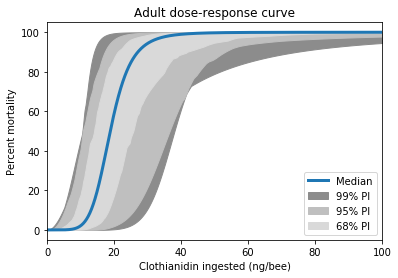

In [84]:
#### DR curve but using MEDIAN curve instead of MAP
def plot_dr_median(df, adult=True, xlim=100, ci=True, percent = [95], sample_num=500, title="Dose-response curve",
                   colors = ['black', 'grey', 'black'], save = False, filename='adult_dr_median'):
    """
    Plot the dose-response curve for a posterior based on maximum a posteriori values.
    Can also include prediction intervals, which are based on weighted random sampling of the particles. 
    """
    if adult:
        ld50_var = "AIAdultLD50"
        slope_var = "AIAdultSlope"
    else:
        ld50_var = "AILarvaLD50"
        slope_var = "AILarvaSlope"
    x, pdf = kde_1d(df,w,ld50_var, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    ld50_median = (x.item(np.min(np.where(cdf > .5))))
    x, pdf = kde_1d(df,w,slope_var, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    slope_median = (x.item(np.min(np.where(cdf > .5))))
    sample = draw_posterior(df, w, sample_num)
    fix, ax = plt.subplots()
    x = np.linspace(0,xlim, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50_median/x)**slope_median) #four parameters Hill equation, equal to what VarroaPop uses
    #print([item for item in zip(x,lower) if item[1] > 1])
    ax.plot(x, y, linewidth=3, label="Median")
    for i, p in enumerate(percent):
        lower, upper = get_prediction_interval(sample, percent=p, max_dose=xlim, adult=adult)
        #ax.plot(x,lower, 'k', linestyle=":", linewidth=2, label="{}% prediction int.".format(p))
        #ax.plot(x,upper, 'k', linestyle=":", linewidth=2)
        ax.fill_between(x,lower,upper, color=colors[i],label="{}% PI".format(p))
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    ax.legend()
    if save:
        plt.savefig('figures/posterior_predictions/dose-response/{}.png'.format(filename,dpi=800))
    plt.show()

#for adults
df, w = history.get_distribution(m=0, t=history.max_t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
random.seed(1254)
plot_dr_median(df, xlim=100, title = "Adult dose-response curve", save=True, filename='adult_dr_median_run3',
               percent=[99,95,68],colors=['0.55','0.75','0.85'])

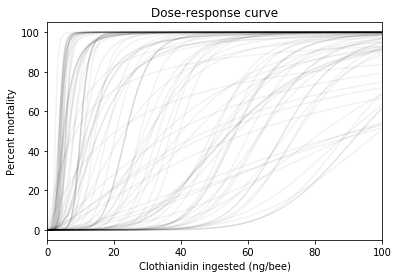

In [25]:
# Multi line plot for larvae
random.seed(1251)
sample = draw_posterior(df, w, 100)

plot_all_dr(sample, xlim=100, adult=False)

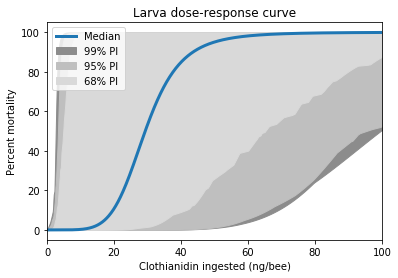

In [83]:
# MAP and PI plot for larvae
random.seed(1251)
plot_dr_median(df, adult=False, title = "Larva dose-response curve", save=True, filename='larva_dr_median_run3',
              percent=[99,95,68],colors=['0.55','0.75','0.85'])

### Draw from the posterior to predict colony-level queen strength and forager lifespan

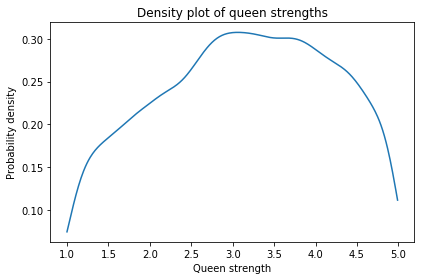

In [29]:
def plot_queenstrength(sample_in, mean_col = 6, sd_col = 7, convert = False, title='Density plot of queen strengths', save = False):
    sample = sample_in.reset_index(drop=True)
    lower = 1
    upper = 5
    step = 0.01
    xlabel = "Queen strength"
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    if convert:
        values_flat = convert_qs_egglaying(values_flat)
        title = 'Density plot of queen egg laying rate'
        lower, upper = 1000,3000
        step = 100
        xlabel = "Max. egg laying rate (eggs/day)"
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, step)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel=xlabel, ylabel='Probability density', title=title)
    plt.tight_layout()
    if save:
        plt.savefig('figures/posterior_predictions/egg_laying_g13_run3.png',dpi=800)
    plt.show()

def convert_qs_egglaying(queen_str):
    egg_rate = (1000*(5-queen_str)+3000*(queen_str-1))/(5-1)
    return egg_rate

random.seed(1251)
sample = draw_posterior(df,w,200)
plot_queenstrength(sample)

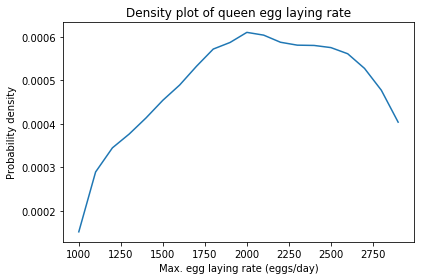

In [30]:
plot_queenstrength(sample, convert = True, save = True)

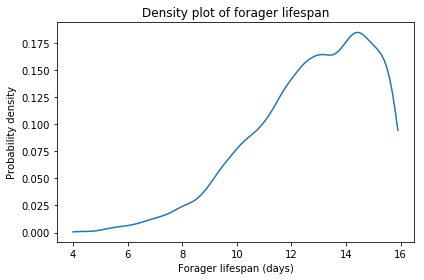

In [12]:
def plot_foragerlifespan(sample_in, mean_col = 4, sd_col=5, title='Density plot of forager lifespan', save = False):
    sample = sample_in.reset_index(drop=True)
    lower = 4
    upper = 16
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .1)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel='Forager lifespan (days)', ylabel='Probability density', title=title)
    plt.tight_layout()
    if save:
        plt.savefig('figures/posterior_predictions/forager_lifespan_g13_run3.png',dpi=800)
    plt.show()
    
random.seed(1251)
sample = draw_posterior(df,w,200)
plot_foragerlifespan(sample, save = True)

### How well does our model predict the feeding study results?

In [22]:
# Pull out our MAP parameters and run it in VarroaPop
#df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee
#MAP_row = np.where(np.max(w)==w)[0][0]
#MAP_pars= df_ug.iloc[MAP_row,:].to_dict()
#MAP_sim_STATIC = simulate_all_dates(MAP_pars)
#np.save("data/MAP_sim_STATIC.npy", MAP_sim_STATIC)

D:\Git_files\bee_neonic_abc\tools\DataSimulator.py:133: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  response_df = pd.DataFrame.from_items(zip(col_names,responses))


In [23]:
# Calculate mean posterior parameters and run in VarroaPop
#df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee
#mean_pars = df_ug.apply(np.average,weights=w, axis=0).to_dict()
#mean_sim_STATIC = simulate_all_dates(mean_pars)
#np.save("data/mean_sim_STATIC.npy", mean_sim_STATIC)

In [7]:
import matplotlib.dates as mdates
import datetime

def posterior_predict(sample_in, ci = 95):
    predictions = np.empty([6,123,len(sample_in.index),7]) # trt x days x sample x response
    sample_dict = sample_in.reset_index(drop=True).to_dict("index")
    vp_inputs = dict()
    for i, (key, pars) in enumerate(sample_dict.items()):
        output = simulate_all_dates(sample_dict[key])
        for j, resp in enumerate(["Adults", "Pupae", "Larvae", "Eggs", "All", "Pollen", "Nectar"]):
            predictions[:,:,i,j] = output[resp]
    return predictions

def get_pp_ci(predictions, ci = 95):
    upper = np.percentile(predictions, 100-(100-ci)/2, axis=2)
    lower = np.percentile(predictions, (100-ci)/2, axis=2)
    median = np.percentile(predictions, 50, axis=2)
    return lower, median, upper

def plot_pop_predictions(response, predictions, field_data, pi="lines", pi_level=[95], save=False, form='mean', fig_form = 'pdf', units = '',
                         colors = ['black', 'grey', 'black'], linetypes = [':', '--', '-.']):
    """ 
    Takes the posterior generation of parameters and 
    plots median or mean posterior and 95% PI colony size vs field data
    """
    resp_index = ["Adults", "Pupae", "Larvae", "Eggs", "All", "Pollen", "Honey"].index(response)
    DATES_STR = ['07/16/2014', '08/08/2014','09/10/2014', '10/15/2014']
    DATES_STR_HIGH = ['07/16/2014', '08/08/2014','09/10/2014', '10/21/2014'] #high had a late CCA7
    initial_df = pd.read_csv('data/bee_counts/initial_conditions.csv', index_col=0)
    initial_df.loc[:,"pollen_mean"] =  initial_df.loc[:,"pollen_mean"].copy() * 0.425
    initial_df.loc[:,"pollen_sd"] =  initial_df.loc[:,"pollen_sd"].copy() * 0.425
    initial_df.loc[:,"honey_mean"] =  initial_df.loc[:,"honey_mean"].copy() * 0.331
    initial_df.loc[:,"honey_sd"] =  initial_df.loc[:,"honey_sd"].copy() * 0.331
    uppers = [np.percentile(predictions, 100-(100-pi)/2, axis=2) for pi in pi_level]
    lowers = [np.percentile(predictions, (100-pi)/2, axis=2) for pi in pi_level]
    #median = np.percentile(contrasts, 50, axis=2)
    if form == 'mean':
        best = np.mean(predictions, axis=2) #this was calculated outside the function
        best_label = "Mean"
    elif form == 'median':  # plot median prediction
        best = np.percentile(predictions, 50, axis=2)
        best_label = "Median"
    else:
        best = None
    fig, axs = plt.subplots(2, 3, figsize=(9,6),sharex=True, sharey=True)
    axs = axs.ravel()
    trts = ["0", "10", "20", "40", "80", "160"]
    trt_labels = ["0", "10", "19", "36", "72", "140"]
    start = datetime.datetime.strptime('06/20/2014', "%m/%d/%Y")
    end = datetime.datetime.strptime('10/21/2014', "%m/%d/%Y")
    date_range = [(start + datetime.timedelta(days=x)) for x in range(0, (end - start).days)]
    days = mdates.DayLocator([10,20])   # every year
    months = mdates.MonthLocator()  # every month
    monthsFmt = mdates.DateFormatter('%B')
    for i, trt in enumerate(trts):
        axs[i].plot(date_range, best[i,:,resp_index], linewidth=3, label=best_label)
        if trt == "160":
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR_HIGH]
        else:
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR]
        if pi == "lines":
            for j, lab in enumerate(pi_level):
                axs[i].plot(date_range,lowers[j][i,:,resp_index], 'k', linestyle=linetypes[j], linewidth=2, color=colors[j],label="{}% PI".format(lab))
                axs[i].plot(date_range,uppers[j][i,:, resp_index], 'k', linestyle=linetypes[j], linewidth=2, color=colors[j])
        if pi == "shaded":
            for j, lab in enumerate(pi_level):
                axs[i].fill_between(date_range,lowers[j][i,:,resp_index],uppers[j][i,:, resp_index] , color=colors[j],label="{}% PI".format(lab))
        empirical_pops = np.append(initial_df.loc[int(trt),response.lower()+"_mean"],
                                   field_data["mean"][i,:,resp_index]) #append start date to otherdates
        empirical_sd = np.append(initial_df.loc[int(trt),response.lower()+"_sd"],field_data["sd"][i,:,resp_index]) #append start date to otherdates
        #axs[i].plot_date([start]+field_dates, empirical_pops, label= "Feeding study data")
        axs[i].errorbar([start]+field_dates, empirical_pops, yerr = empirical_sd, fmt='o',color = 'tab:orange', label = "Feeding study data")
        axs[i].set_title(trt_labels[i]+" \u03BCg/kg clothianidin")
        axs[i].xaxis.set_major_locator(months)
        axs[i].xaxis.set_major_formatter(monthsFmt)
        axs[i].xaxis.set_minor_locator(days)
        axs[i].set_ylim(bottom=0)
        if i in [0,3]:
            axs[i].set(ylabel="{} per colony{}".format(response, units))
    handles, labels = axs[i].get_legend_handles_labels()
    fig.autofmt_xdate()
    fig.tight_layout()
    lgd = plt.legend(handles,labels, loc='center left', bbox_to_anchor=(1, 1), prop={'size': 12})
    if save:
        plt.savefig('figures/posterior_predictions/bee_population/run3/{}.{}'.format(response, fig_form),
                    bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    
def convert_data_dict(data_dict):
    """
    Convert the dictionary of study populations by trt and time
    into a 3d array (treatment x time x response var). Also add
    a mean for all individuals
    """
    out = {}
    for stat in ["mean", "sd"]:
        out_stat = np.empty([6, 4, 7])
        for h, h_str in enumerate(["Adults", "Pupae", "Larvae", "Eggs", "All", "Pollen", "Honey"]):
            for i, i_str in enumerate(["0", "10", "20", "40", "80", "160"]):
                for j, j_str in enumerate(["4", "5", "6", "7"]):
                    if h_str == "All":
                        if stat == "sd":
                            continue
                        else:
                            key_a = i_str+"_"+j_str+"_{}_{}".format("Adults", stat)
                            key_p = i_str+"_"+j_str+"_{}_{}".format("Pupae", stat)
                            key_l = i_str+"_"+j_str+"_{}_{}".format("Larvae", stat)
                            key_e = i_str+"_"+j_str+"_{}_{}".format("Eggs", stat)
                            out_stat[i,j,h] = data_dict[key_a] + data_dict[key_p] + data_dict[key_l] + data_dict[key_e]
                    else:
                        key = i_str+"_"+j_str+"_{}_{}".format(h_str, stat)
                        out_stat[i,j,h] = data_dict[key]
                    if h_str == "Pollen":
                        out_stat[i,j,h] = out_stat[i,j,h] * 0.425  # convert from cells to grams
                    if h_str == "Honey":
                        out_stat[i,j,h] = out_stat[i,j,h] * 0.331  # convert from cells to grams
        out[stat] = out_stat
    return out

In [8]:
field_data = convert_data_dict(study_data_all)
df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee

In [10]:
#random.seed(1251)
#sample = draw_posterior(df_ug,w,200) #normally 200
#predictions = posterior_predict(sample)
#lower_pi, median, upper_pi = get_pp_ci(predictions)
#np.save("data/predictions_pollen.npy", predictions)
#np.save("data/lower_pi.npy", lower_pi)
#np.save("data/upper_pi.npy", upper_pi)

D:\Git_files\bee_neonic_abc\tools\DataSimulator.py:134: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  response_df = pd.DataFrame.from_items(zip(col_names,responses))


In [9]:
# Load pre-processed variables from above code block
#MAP_sim_STATIC = np.load("data/MAP_sim_STATIC.npy").item()
#mean_sim_STATIC = np.load("data/mean_sim_STATIC.npy").item()
lower_pi = np.load("data/lower_pi.npy")
upper_pi = np.load("data/upper_pi.npy")
predictions = np.load("data/predictions_pollen.npy")

In [33]:
#pull out a field value upper/lower sd range 
field_data['mean'][5,3,0] + field_data['sd'][5,3,0]

827.0

In [32]:
#pull out a predicted upper/lower limit 
import matplotlib.dates as mdates
import datetime

start = datetime.datetime.strptime('06/20/2014', "%m/%d/%Y")
end = datetime.datetime.strptime('10/21/2014', "%m/%d/%Y")
date_range = [(start + datetime.timedelta(days=x)) for x in range(0, (end - start).days)]
lower_pi[5,date_range.index(datetime.datetime.strptime('10/20/2014', "%m/%d/%Y")),0]

3456.0875

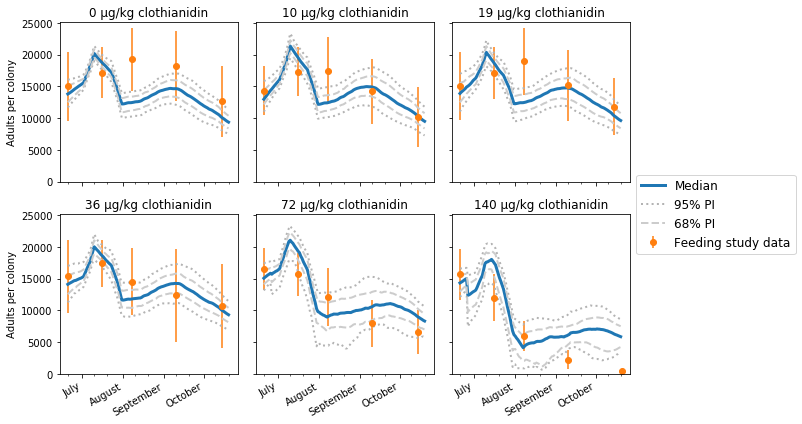

In [182]:
plot_pop_predictions('Adults', predictions, field_data, form='median', save = False, fig_form='png', pi="lines",  pi_level=[95, 68], colors =  ['0.7','0.8'])

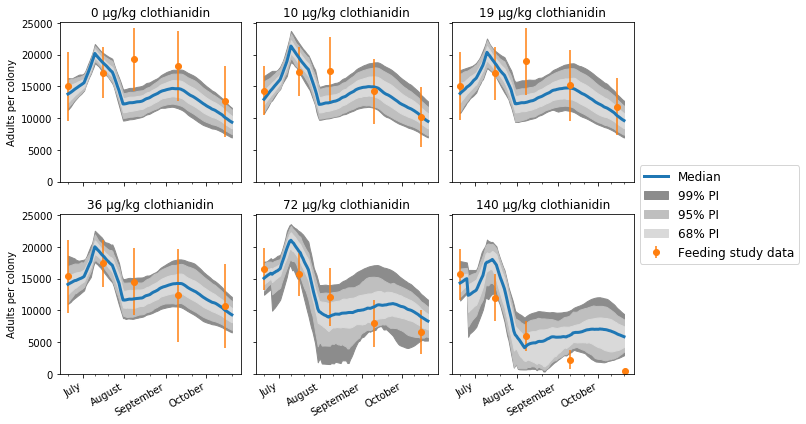

In [13]:
plot_pop_predictions('Adults', predictions, field_data, form='median', save = True, fig_form='png', pi="shaded",
                     pi_level=[99,95, 68], colors=['0.55','0.75','0.85'])

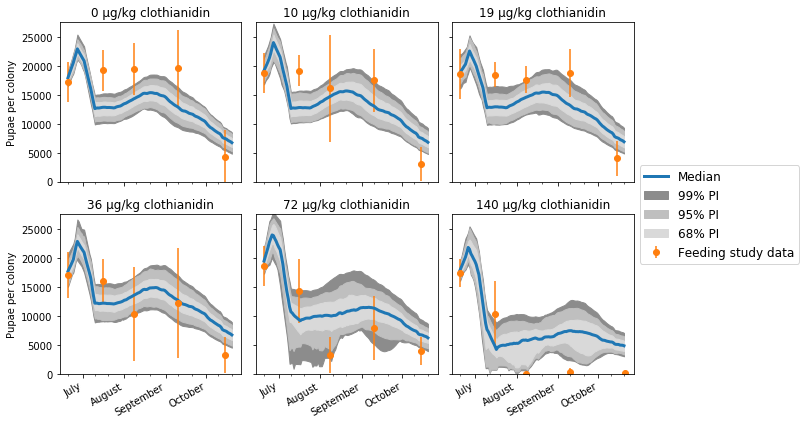

In [14]:
plot_pop_predictions('Pupae', predictions, field_data, form='median', save = True, fig_form='png', pi="shaded",
                     pi_level=[99,95, 68],colors=['0.55','0.75','0.85'])

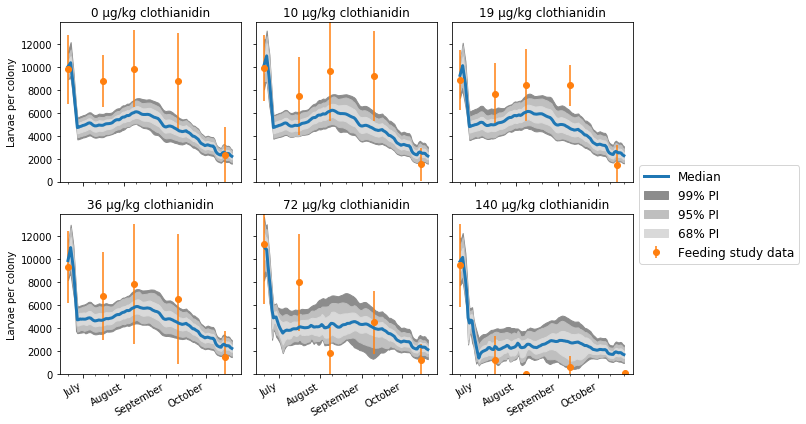

In [15]:
plot_pop_predictions('Larvae', predictions, field_data, form='median', save = True, fig_form='png', pi="shaded",
                     pi_level=[99,95, 68],colors=['0.55','0.75','0.85'])

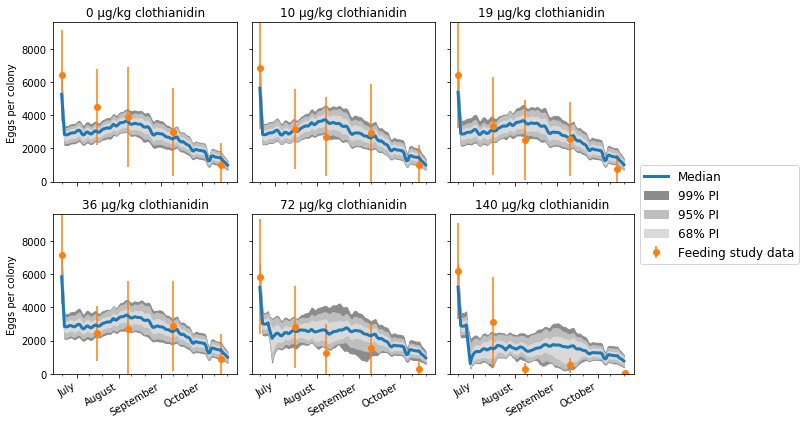

In [16]:
#field_data = convert_data_dict(study_data_all)
plot_pop_predictions('Eggs', predictions, field_data, form='median', save = True, fig_form='png', pi="shaded",
                     pi_level=[99,95, 68],colors=['0.55','0.75','0.85'])

In [70]:
#plot_pop_predictions('All', df_ug, w, field_data, lower=lower_pi, upper=upper_pi, save = False, fig_form='png')

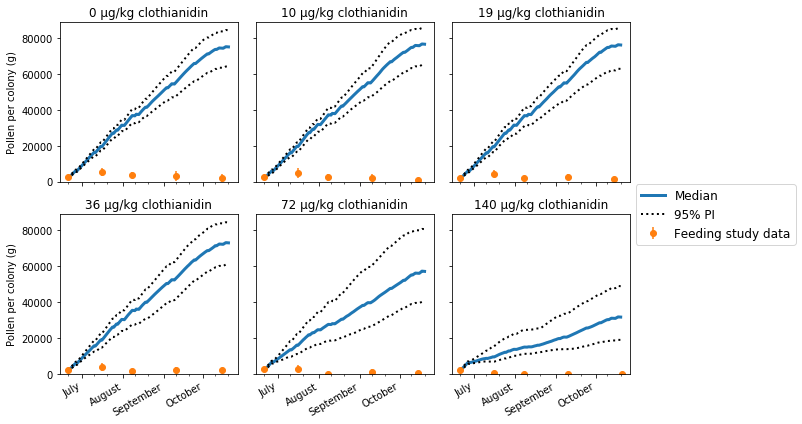

In [40]:
plot_pop_predictions('Pollen', predictions, field_data, form='median', save = True, fig_form='png', units = ' (g)')

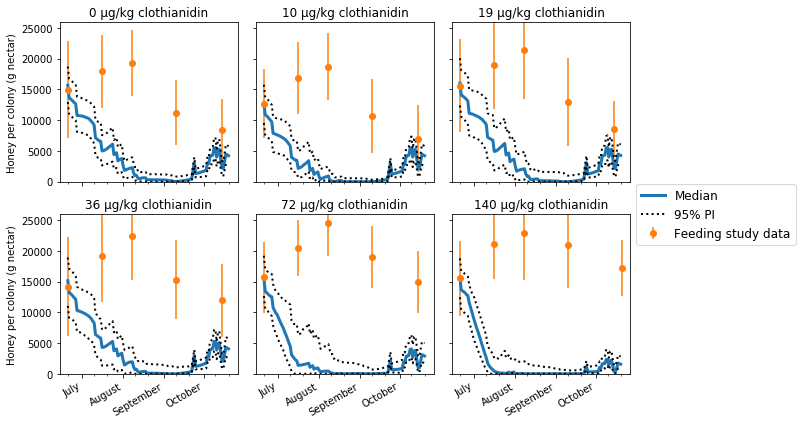

In [41]:
plot_pop_predictions('Honey', predictions, field_data, form='median', save = True, fig_form='png', units = ' (g nectar)')

In [12]:
def plot_trt_contrasts(response, df_in, field_data, pi="lines", pi_level=[95], save=False, transparent=False, fig_form = 'pdf',
                      colors = ['black', 'grey', 'black'], line_color = "C0", linetypes = [':', '--', '-.'], y_low_lim = None):
    df = df_in.copy()  # trt x days x sample x response
    initial_df = pd.read_csv('data/bee_counts/initial_conditions.csv', index_col=0)
    initial_df.loc[:,"pollen_mean"] =  initial_df.loc[:,"pollen_mean"].copy() * 0.425  # convert from cells to grams
    initial_df.loc[:,"pollen_sd"] =  initial_df.loc[:,"pollen_sd"].copy() * 0.425  # convert from cells to grams
    initial_df.loc[:,"honey_mean"] =  initial_df.loc[:,"honey_mean"].copy() * 0.331  # convert from cells to grams
    initial_df.loc[:,"honey_sd"] =  initial_df.loc[:,"honey_sd"].copy() * 0.331  # convert from cells to grams
    initial_df['all_mean'] = initial_df['adults_mean'] + initial_df['pupae_mean'] + initial_df['larvae_mean'] + initial_df['eggs_mean']
    initial_df_delta = initial_df - initial_df.loc[0].values.squeeze()
    initial_df_delta = initial_df_delta.drop(0,axis=0)
    contrasts = np.subtract(df,df[0,:,:,:])
    contrasts = np.delete(contrasts,0,0) #delete our control row
    uppers = [np.percentile(contrasts, 100-(100-pi)/2, axis=2) for pi in pi_level]
    lowers = [np.percentile(contrasts, (100-pi)/2, axis=2) for pi in pi_level]
    median = np.percentile(contrasts, 50, axis=2)
    fig, axs = plt.subplots(2, 3, figsize=(9,6),sharex=True, sharey=True)
    axs = axs.ravel()
    fig.delaxes(axs[5])  # delete our empty subplot
    axs[2].xaxis.set_tick_params(which='both', labelbottom=True)  # add back tick labels for far right plot
    resp_index = ["Adults", "Pupae", "Larvae", "Eggs", "All", "Pollen", "Honey"].index(response)
    DATES_STR = ['07/16/2014', '08/08/2014','09/10/2014', '10/15/2014']
    DATES_STR_HIGH = ['07/16/2014', '08/08/2014','09/10/2014', '10/21/2014'] #high had a late CCA7
    trts = ["10", "20", "40", "80", "160"]
    trt_labels = ["0", "10", "19", "36", "72", "140"]
    start = datetime.datetime.strptime('06/20/2014', "%m/%d/%Y")
    end = datetime.datetime.strptime('10/21/2014', "%m/%d/%Y")
    date_range = [(start + datetime.timedelta(days=x)) for x in range(0, (end - start).days)]
    days = mdates.DayLocator([10,20])   # every year
    months = mdates.MonthLocator()  # every month
    monthsFmt = mdates.DateFormatter('%B')
    for i, trt in enumerate(trts):
        axs[i].plot(date_range, median[i,:,resp_index], linewidth=3, label="Median",color=line_color)
        axs[i].axhline(y=0, color="black", linewidth=3)
        if trt == "160":
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR_HIGH]
        else:
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR]
        if pi == "lines":
            for j, lab in enumerate(pi_level):
                axs[i].plot(date_range,lowers[j][i,:,resp_index], 'k', linestyle=linetypes[j], linewidth=2, color=colors[j],label="{}% PI".format(lab))
                axs[i].plot(date_range,uppers[j][i,:, resp_index], 'k', linestyle=linetypes[j], linewidth=2, color=colors[j])
        if pi == "shaded":
            for j, lab in enumerate(pi_level):
                axs[i].fill_between(date_range,lowers[j][i,:,resp_index],uppers[j][i,:, resp_index] , color=colors[j],label="{}% PI".format(lab))
        empirical_pops = np.append(initial_df_delta.loc[int(trt),response.lower()+"_mean"],
                                   (field_data["mean"][i+1,:,resp_index] - field_data["mean"][0,:,resp_index]))
        try:
            empirical_sd = np.append(initial_df.loc[int(trt),response.lower()+"_sd"],
                                     np.sqrt(np.square(field_data["sd"][i+1,:,resp_index]) + np.square(field_data["sd"][0,:,resp_index]))) #append start date to otherdates
        except KeyError:
            empirical_sd = None
        axs[i].errorbar([start]+field_dates, empirical_pops, yerr=empirical_sd, fmt='o',color = 'tab:orange', label = "Feeding study data")
        axs[i].set_title(trt_labels[i+1]+" \u03BCg/kg clothianidin")
        axs[i].xaxis.set_major_locator(months)
        axs[i].xaxis.set_major_formatter(monthsFmt)
        axs[i].xaxis.set_minor_locator(days)
        if i in [0,3]:
            axs[i].set(ylabel="Change in {} from control".format(response.lower()))
        if y_low_lim:
            axs[i].set_ylim(bottom=y_low_lim)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.autofmt_xdate()
    plt.setp(axs[2].get_xticklabels(),visible=True, color='black', rotation=30, ha='right')  # format labels for far r plot
    fig.tight_layout()
    lgd = plt.legend(handles,labels, loc='center', bbox_to_anchor=(1.5, 0.5), prop={'size': 12})
    t_label = ""
    if transparent:
        fig.patch.set_alpha(0.0)
        t_label = "_transparent"
    if save:
        plt.savefig('figures/posterior_predictions/bee_population/run3/{}_contrast{}.{}'.format(response, t_label, fig_form,),
                    bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=100)
    plt.show()
    
    

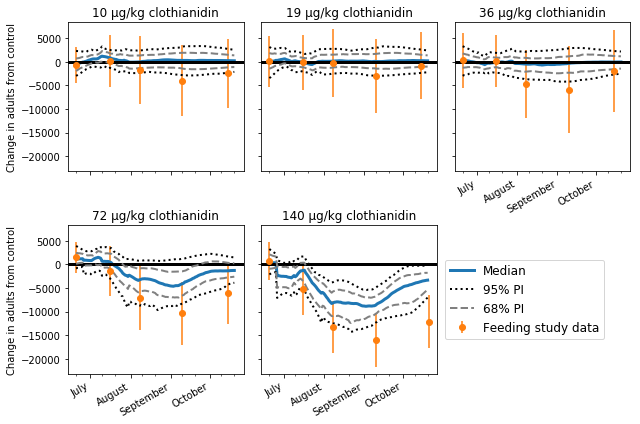

In [18]:
field_data = convert_data_dict(study_data_all)
plot_trt_contrasts('Adults', predictions, field_data, save=True, transparent=False, fig_form='png', pi="lines", pi_level=[95, 68])

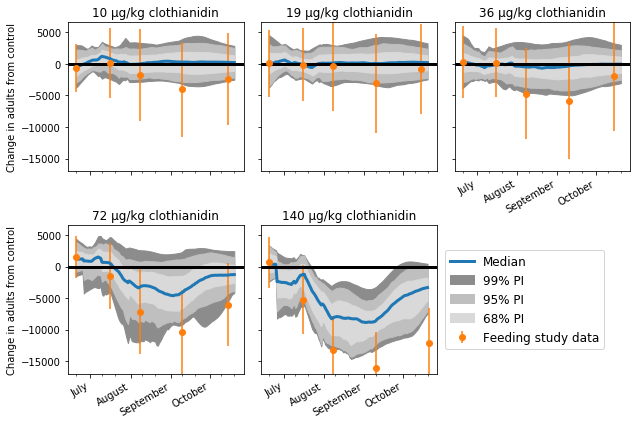

In [45]:
field_data = convert_data_dict(study_data_all)
plot_trt_contrasts('Adults', predictions, field_data, save=True, transparent=False, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'], y_low_lim=-17000)

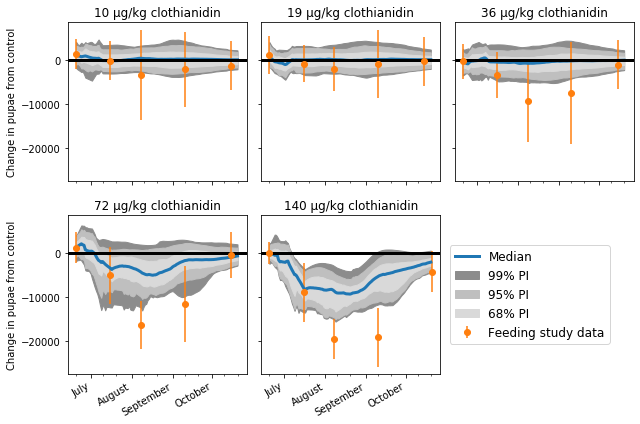

In [17]:
plot_trt_contrasts('Pupae', predictions, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'])

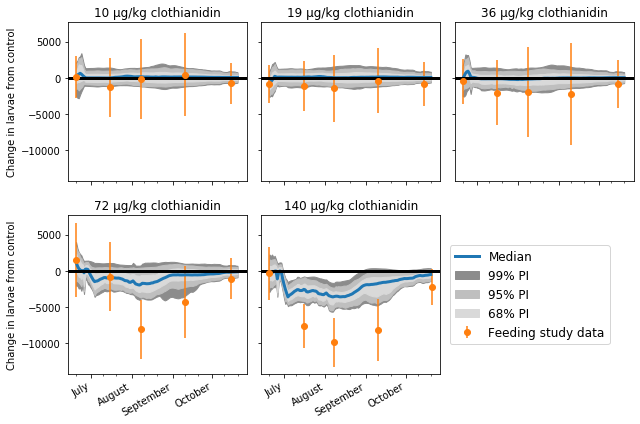

In [18]:
plot_trt_contrasts('Larvae', predictions, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'])

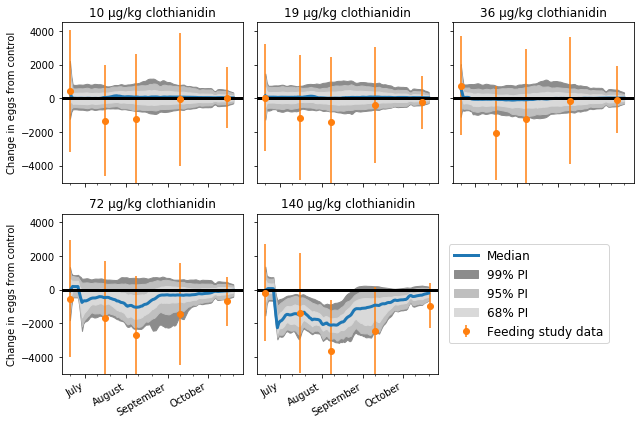

In [70]:
plot_trt_contrasts('Eggs', predictions, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'], y_low_lim=-5000)

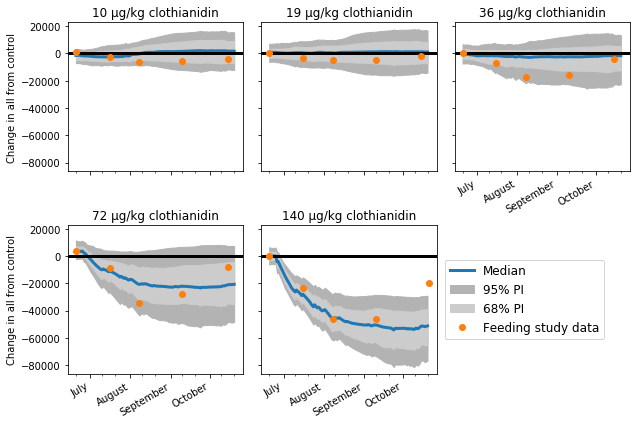

In [195]:
plot_trt_contrasts('All', predictions, field_data, save = True, fig_form='png', pi="shaded", pi_level=[95, 68],
                  colors =  ['0.7','0.8'])

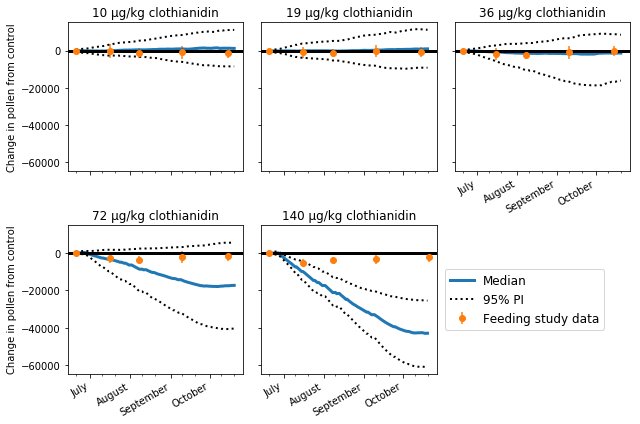

In [84]:
plot_trt_contrasts('Pollen', predictions, field_data, save = True, fig_form='png')

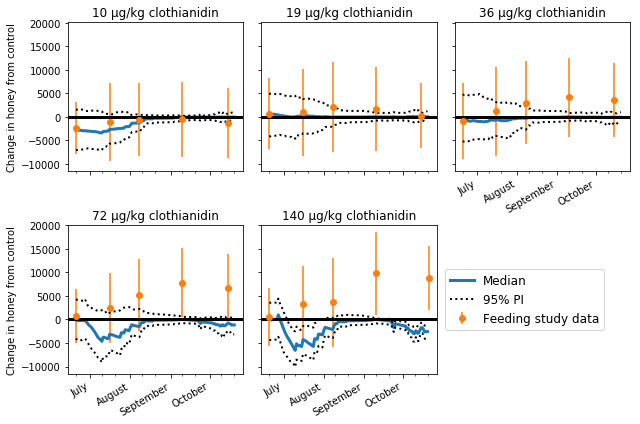

In [85]:
plot_trt_contrasts('Honey', predictions, field_data, save = True, fig_form='png')

##### Let's calculate the % of time each treatment was significantly lower than the control (counting from start of treatments)

In [10]:
def effect_period(response, df_in, pi_level=95, trts = ["10", "19", "36", "72", "140"]):
    df = df_in.copy()  # trt x days x sample x response
    resp_index = ["Adults", "Pupae", "Larvae", "Eggs", "All"].index(response)
    contrasts = np.subtract(df,df[0,:,:,:])
    contrasts = np.delete(contrasts,0,0) #delete our control row
    upper = np.percentile(contrasts, 100-(100-pi_level)/2, axis=2)
    upper = upper[:,6:,:]# remove 6 days before trts started
    effects = [None, None ,None, None, None]
    for i, trt in enumerate(trts):
        sig_diff = np.where(upper[i,:, resp_index] < 0,1,0)
        percent_diff = sig_diff.sum() / len(sig_diff) * 100
        effects[i] = (trt,  f'{percent_diff:.{1}f} %')
    return effects

### 95% PI:

In [43]:
effect_period("Adults", predictions, pi_level=95)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '78.6 %')]

In [44]:
effect_period("Pupae", predictions, pi_level=95)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '87.2 %')]

In [45]:
effect_period("Larvae", predictions, pi_level=95)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '85.5 %')]

In [46]:
effect_period("Eggs", predictions, pi_level=95)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '84.6 %')]

### 90% PI:

In [63]:
effect_period("Adults", predictions, pi_level=90)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '79.5 %')]

In [48]:
effect_period("Pupae", predictions, pi_level=90)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '91.5 %')]

In [49]:
effect_period("Larvae", predictions, pi_level=90)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '90.6 %')]

In [50]:
effect_period("Eggs", predictions, pi_level=90)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '89.7 %')]

### 68% PI:

In [51]:
effect_period("Adults", predictions, pi_level=68)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '50.4 %'),
 ('140', '95.7 %')]

In [52]:
effect_period("Pupae", predictions, pi_level=68)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '49.6 %'),
 ('140', '92.3 %')]

In [53]:
effect_period("Larvae", predictions, pi_level=68)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '46.2 %'),
 ('140', '96.6 %')]

In [54]:
effect_period("Eggs", predictions, pi_level=68)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '35.9 %'),
 ('140', '99.1 %')]

## 99% PI

In [10]:
effect_period("Adults", predictions, pi_level=99)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '55.6 %')]

In [11]:
effect_period("Pupae", predictions, pi_level=99)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '53.0 %')]

In [12]:
effect_period("Larvae", predictions, pi_level=99)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '50.4 %')]

In [13]:
effect_period("Eggs", predictions, pi_level=99)

[('10', '0.0 %'),
 ('19', '0.0 %'),
 ('36', '0.0 %'),
 ('72', '0.0 %'),
 ('140', '49.6 %')]

#### Predictions for non-tested concentrations

In [11]:
def posterior_predict_untested(sample_in, ci = 95):
    predictions = np.empty([6,123,len(sample_in.index),5]) # trt x days x sample x response
    sample_dict = sample_in.reset_index(drop=True).to_dict("index")
    vp_inputs = dict()
    for i, (key, pars) in enumerate(sample_dict.items()):
        output = simulate_all_dates_p(sample_dict[key])
        for j, resp in enumerate(["Adults", "Pupae", "Larvae", "Eggs", "All"]):
            predictions[:,:,i,j] = output[resp]
    return predictions

In [65]:
#field_data = convert_data_dict(study_data_all)
#df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee
#random.seed(1251)
#sample = draw_posterior(df_ug,w,200) #normally 200
#predictions = posterior_predict_untested(sample)
#lower_pi, median, upper_pi = get_pp_ci(predictions)
#np.save("data/predictions_predict.npy", predictions)
#np.save("data/lower_pi_predict.npy", lower_pi)
#np.save("data/upper_pi_predict.npy", upper_pi)

D:\Git_files\bee_neonic_abc\tools\DataSimulatorPredict.py:46: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  response_df = pd.DataFrame.from_items(zip(col_names,responses))


In [12]:
field_data = convert_data_dict(study_data_all)
df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee
#random.seed(1251)
#sample = draw_posterior(df_ug,w,200) #normally 200
#predictions = posterior_predict_untested(sample)
#lower_pi, median, upper_pi = get_pp_ci(predictions)
#np.save("data/predictions_predict_75_95.npy", predictions)
#np.save("data/lower_pi_predict_75_95.npy", lower_pi)
#np.save("data/upper_pi_predict_75_95.npy", upper_pi)

In [13]:
predictions_p = np.load("data/predictions_predict_75_95.npy")
lower_pi_p = np.load("data/lower_pi_predict_75_95.npy")
upper_pi_p = np.load("data/upper_pi_predict_75_95.npy")

In [14]:
predictions_p_low = np.load("data/predictions_predict.npy")

In [24]:
def plot_trt_contrasts_untested(response, df_in, field_data, trts=["75", "80", "85", "90", "95"], pi="lines", pi_level=[95], save=False, filename='contrast_hypo', fig_form = 'pdf',
                      colors = ['black', 'grey', 'black'], linetypes = [':', '--', '-.']):
    df = df_in.copy()  # trt x days x sample x response
    initial_df = pd.read_csv('data/bee_counts/initial_conditions.csv', index_col=0)
    initial_df['all_mean'] = initial_df['adults_mean'] + initial_df['pupae_mean'] + initial_df['larvae_mean'] + initial_df['eggs_mean']
    initial_df_delta = initial_df - initial_df.loc[0].values.squeeze()
    initial_df_delta = initial_df_delta.drop(0,axis=0)
    contrasts = np.subtract(df,df[0,:,:,:])
    contrasts = np.delete(contrasts,0,0) #delete our control row
    uppers = [np.percentile(contrasts, 100-(100-pi)/2, axis=2) for pi in pi_level]
    lowers = [np.percentile(contrasts, (100-pi)/2, axis=2) for pi in pi_level]
    median = np.percentile(contrasts, 50, axis=2)
    fig, axs = plt.subplots(2, 3, figsize=(9,6),sharex=True, sharey=True)
    axs = axs.ravel()
    fig.delaxes(axs[5])  # delete our empty subplot
    axs[2].xaxis.set_tick_params(which='both', labelbottom=True)  # add back tick labels for far right plot
    resp_index = ["Adults", "Pupae", "Larvae", "Eggs", "All"].index(response)
    DATES_STR = ['07/16/2014', '08/08/2014','09/10/2014', '10/15/2014']
    #DATES_STR_HIGH = ['07/16/2014', '08/08/2014','09/10/2014', '10/21/2014'] #high had a late CCA7
    start = datetime.datetime.strptime('06/20/2014', "%m/%d/%Y")
    end = datetime.datetime.strptime('10/21/2014', "%m/%d/%Y")
    date_range = [(start + datetime.timedelta(days=x)) for x in range(0, (end - start).days)]
    days = mdates.DayLocator([10,20])   # every year
    months = mdates.MonthLocator()  # every month
    monthsFmt = mdates.DateFormatter('%B')
    for i, trt in enumerate(trts):
        axs[i].plot(date_range, median[i,:,resp_index], linewidth=3, label="Median")
        axs[i].axhline(y=0, color="black", linewidth=3)
        if trt == "160":
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR_HIGH]
        else:
            field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR]
        if pi == "lines":
            for j, lab in enumerate(pi_level):
                axs[i].plot(date_range,lowers[j][i,:,resp_index], 'k', linestyle=linetypes[j], linewidth=2, color=colors[j],label="{}% PI".format(lab))
                axs[i].plot(date_range,uppers[j][i,:, resp_index], 'k', linestyle=linetypes[j], linewidth=2, color=colors[j])
        if pi == "shaded":
            for j, lab in enumerate(pi_level):
                axs[i].fill_between(date_range,lowers[j][i,:,resp_index],uppers[j][i,:, resp_index] , color=colors[j],label="{}% PI".format(lab))
        axs[i].set_title(trt +" \u03BCg/kg clothianidin")
        axs[i].xaxis.set_major_locator(months)
        axs[i].xaxis.set_major_formatter(monthsFmt)
        axs[i].xaxis.set_minor_locator(days)
        if i in [0,3]:
            axs[i].set(ylabel="Change in {} from control".format(response.lower()))
    handles, labels = axs[0].get_legend_handles_labels()
    fig.autofmt_xdate()
    plt.setp(axs[2].get_xticklabels(),visible=True, color='black', rotation=30, ha='right')  # format labels for far r plot
    fig.tight_layout()
    lgd = plt.legend(handles,labels, loc='center', bbox_to_anchor=(1.5, 0.5), prop={'size': 12})
    if save:
        plt.savefig('figures/posterior_predictions/bee_population/run3/{}_{}.{}'.format(response, filename, fig_form),
                    bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=100)
    plt.show()
    

#### 75 to 95 ug/kg

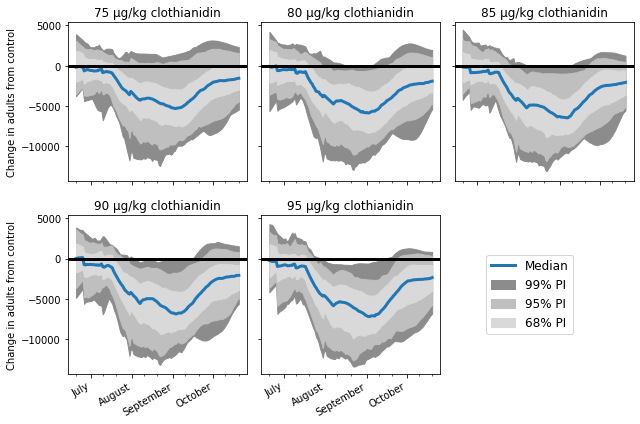

In [28]:
field_data = convert_data_dict(study_data_all)
plot_trt_contrasts_untested('Adults', predictions_p, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'])

In [29]:
effect_period("Adults", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=68)

[('75', '80.3 %'),
 ('80', '79.5 %'),
 ('85', '80.3 %'),
 ('90', '80.3 %'),
 ('95', '81.2 %')]

In [30]:
effect_period("Adults", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=95)

[('75', '0.0 %'),
 ('80', '39.3 %'),
 ('85', '49.6 %'),
 ('90', '48.7 %'),
 ('95', '53.0 %')]

In [31]:
effect_period("Adults", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=99)

[('75', '0.0 %'),
 ('80', '9.4 %'),
 ('85', '21.4 %'),
 ('90', '36.8 %'),
 ('95', '41.0 %')]

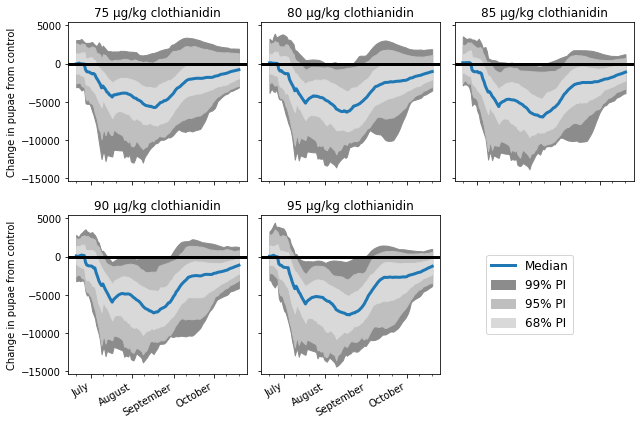

In [32]:
plot_trt_contrasts_untested('Pupae', predictions_p, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'])

In [33]:
effect_period("Pupae", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=68)

[('75', '88.0 %'),
 ('80', '88.9 %'),
 ('85', '92.3 %'),
 ('90', '91.5 %'),
 ('95', '92.3 %')]

In [34]:
effect_period("Pupae", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=95)

[('75', '0.0 %'),
 ('80', '40.2 %'),
 ('85', '47.0 %'),
 ('90', '47.9 %'),
 ('95', '50.4 %')]

In [35]:
effect_period("Pupae", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=99)

[('75', '0.0 %'),
 ('80', '11.1 %'),
 ('85', '15.4 %'),
 ('90', '34.2 %'),
 ('95', '41.9 %')]

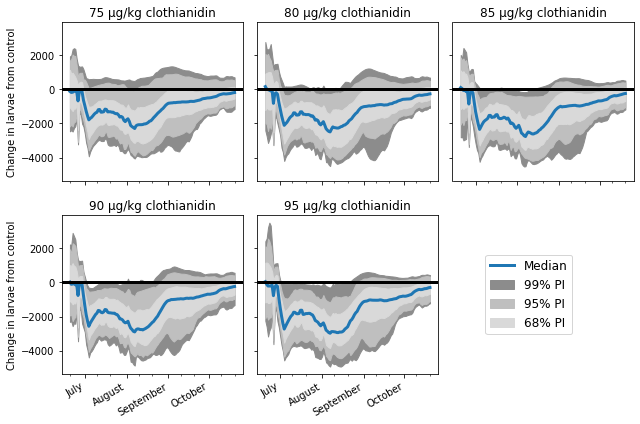

In [37]:
plot_trt_contrasts_untested('Larvae', predictions_p, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'])

In [38]:
effect_period("Larvae", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=68)

[('75', '82.1 %'),
 ('80', '85.5 %'),
 ('85', '88.0 %'),
 ('90', '92.3 %'),
 ('95', '92.3 %')]

In [39]:
effect_period("Larvae", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=95)

[('75', '5.1 %'),
 ('80', '42.7 %'),
 ('85', '47.0 %'),
 ('90', '47.0 %'),
 ('95', '48.7 %')]

In [40]:
effect_period("Larvae", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=99)

[('75', '0.0 %'),
 ('80', '4.3 %'),
 ('85', '12.0 %'),
 ('90', '22.2 %'),
 ('95', '41.0 %')]

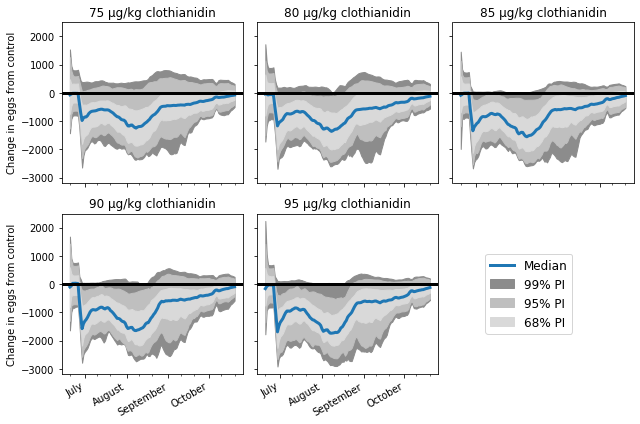

In [41]:
plot_trt_contrasts_untested('Eggs', predictions_p, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'])

In [42]:
effect_period("Eggs", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=68)

[('75', '79.5 %'),
 ('80', '83.8 %'),
 ('85', '87.2 %'),
 ('90', '90.6 %'),
 ('95', '91.5 %')]

In [43]:
effect_period("Eggs", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=95)

[('75', '0.0 %'),
 ('80', '32.5 %'),
 ('85', '47.0 %'),
 ('90', '47.0 %'),
 ('95', '47.9 %')]

In [44]:
effect_period("Eggs", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=99)

[('75', '0.0 %'),
 ('80', '0.9 %'),
 ('85', '10.3 %'),
 ('90', '2.6 %'),
 ('95', '7.7 %')]

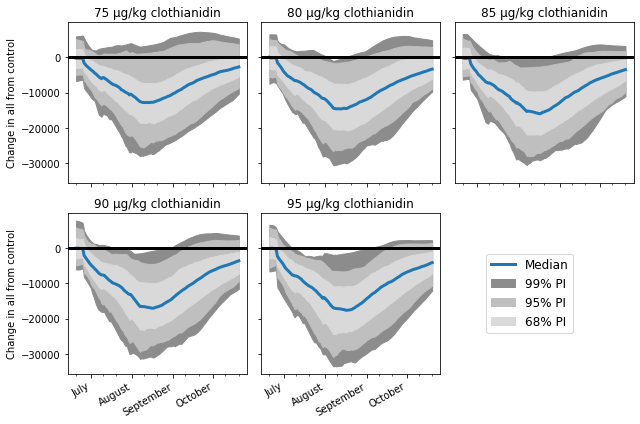

In [45]:
plot_trt_contrasts_untested('All', predictions_p, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'])

In [46]:
effect_period("All", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=68)

[('75', '97.4 %'),
 ('80', '94.0 %'),
 ('85', '98.3 %'),
 ('90', '98.3 %'),
 ('95', '98.3 %')]

In [47]:
effect_period("All", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=95)

[('75', '0.0 %'),
 ('80', '29.9 %'),
 ('85', '57.3 %'),
 ('90', '53.8 %'),
 ('95', '65.0 %')]

In [48]:
effect_period("All", predictions_p, trts = ["75", "80", "85", "90", "95"], pi_level=99)

[('75', '0.0 %'),
 ('80', '11.1 %'),
 ('85', '24.8 %'),
 ('90', '31.6 %'),
 ('95', '48.7 %')]

#### 50 to 70 ug/kg

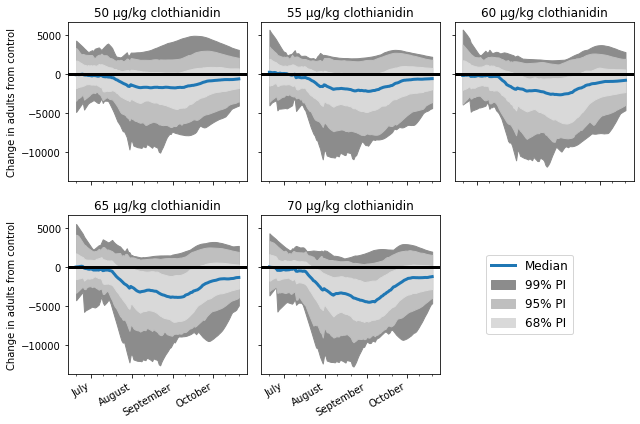

In [49]:
field_data = convert_data_dict(study_data_all)
plot_trt_contrasts_untested('Adults', predictions_p_low, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'], trts=["50", "55", "60", "65", "70"], filename = "contrasts_hypo_low")

In [50]:
effect_period("Adults", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=68)

[('50', '0.0 %'),
 ('55', '13.7 %'),
 ('60', '40.2 %'),
 ('65', '45.3 %'),
 ('70', '54.7 %')]

In [51]:
effect_period("Adults", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=95)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

In [52]:
effect_period("Adults", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=99)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

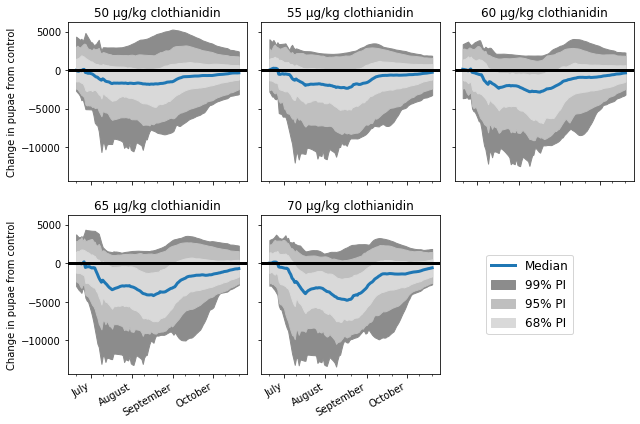

In [53]:
plot_trt_contrasts_untested('Pupae', predictions_p_low, field_data, save = True, fig_form='png', pi="shaded", pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'], trts=["50", "55", "60", "65", "70"], filename = "contrasts_hypo_low")

In [54]:
effect_period("Pupae", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=68)

[('50', '0.0 %'),
 ('55', '12.8 %'),
 ('60', '41.0 %'),
 ('65', '43.6 %'),
 ('70', '51.3 %')]

In [55]:
effect_period("Pupae", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=95)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

In [56]:
effect_period("Pupae", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=99)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

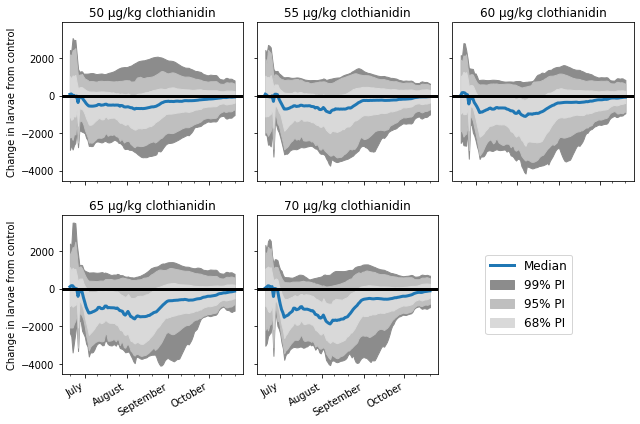

In [57]:
plot_trt_contrasts_untested('Larvae', predictions_p_low, field_data, save = True, fig_form='png', pi="shaded",pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'], trts=["50", "55", "60", "65", "70"], filename = "contrasts_hypo_low")

In [51]:
effect_period("Larvae", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=68)

[('50', '0.9 %'),
 ('55', '7.7 %'),
 ('60', '40.2 %'),
 ('65', '43.6 %'),
 ('70', '49.6 %')]

In [59]:
effect_period("Larvae", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=95)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

In [60]:
effect_period("Larvae", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=99)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

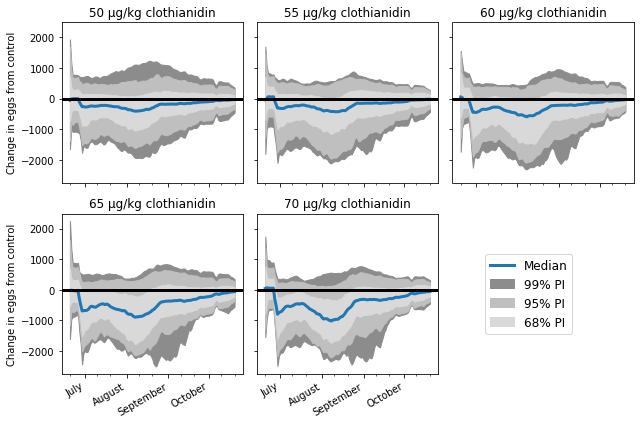

In [85]:
plot_trt_contrasts_untested('Eggs', predictions_p_low, field_data, save = True, fig_form='png', pi="shaded",pi_level=[99,95, 68],
                  trts=["50", "55", "60", "65", "70"], colors=['0.55','0.75','0.85'], filename = "contrasts_hypo_low")

In [62]:
effect_period("Eggs", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=68)

[('50', '0.0 %'),
 ('55', '0.9 %'),
 ('60', '13.7 %'),
 ('65', '41.9 %'),
 ('70', '47.9 %')]

In [63]:
effect_period("Eggs", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=95)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

In [64]:
effect_period("Eggs", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=99)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

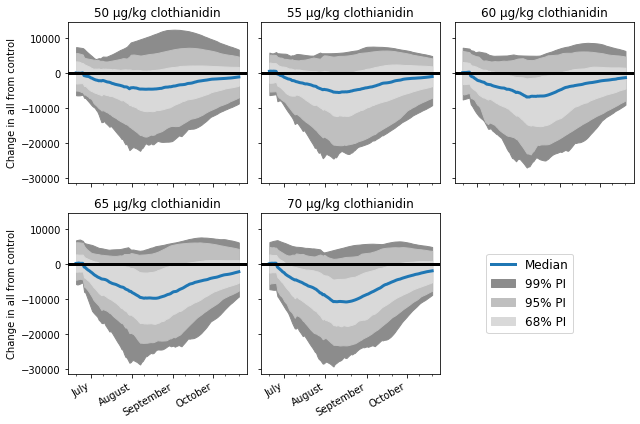

In [65]:
plot_trt_contrasts_untested('All', predictions_p_low, field_data, save = True, fig_form='png', pi="shaded",pi_level=[99,95, 68],
                  colors=['0.55','0.75','0.85'], trts=["50", "55", "60", "65", "70"], filename = "contrasts_hypo_low")

In [66]:
effect_period("All", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=68)

[('50', '0.0 %'),
 ('55', '1.7 %'),
 ('60', '38.5 %'),
 ('65', '42.7 %'),
 ('70', '69.2 %')]

In [67]:
effect_period("All", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=95)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

In [68]:
effect_period("All", predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=99)

[('50', '0.0 %'),
 ('55', '0.0 %'),
 ('60', '0.0 %'),
 ('65', '0.0 %'),
 ('70', '0.0 %')]

### Mean effect periods across all endpoints

In [137]:
def mean_effect_period(df_in, pi_level=95, trts = ["10", "19", "36", "72", "140"]):
    endpoints = ["Adults", "Pupae", "Larvae", "Eggs"]
    total = np.zeros(len(trts))
    print('Treatments: {}'.format(trts))
    for ep in endpoints:
        result = effect_period(ep, df_in, pi_level,trts)
        period = [float(p[1][0:4]) for p in result]
        print('{}: {}'.format(ep,period))
        total = total + np.array(period)
    print('Mean: {}'.format(np.around(total / len(endpoints), 1)))

#### Tested concentrations

In [138]:
mean_effect_period(predictions, pi_level=68)

Treatments: ['10', '19', '36', '72', '140']
Adults: [0.0, 0.0, 0.0, 50.4, 95.7]
Pupae: [0.0, 0.0, 0.0, 49.6, 92.3]
Larvae: [0.0, 0.0, 0.0, 46.2, 96.6]
Eggs: [0.0, 0.0, 0.0, 35.9, 99.1]
Mean: [ 0.   0.   0.  45.5 95.9]


In [139]:
mean_effect_period(predictions, pi_level=95)

Treatments: ['10', '19', '36', '72', '140']
Adults: [0.0, 0.0, 0.0, 0.0, 78.6]
Pupae: [0.0, 0.0, 0.0, 0.0, 87.2]
Larvae: [0.0, 0.0, 0.0, 0.0, 85.5]
Eggs: [0.0, 0.0, 0.0, 0.0, 84.6]
Mean: [ 0.  0.  0.  0. 84.]


In [140]:
mean_effect_period(predictions, pi_level=99)

Treatments: ['10', '19', '36', '72', '140']
Adults: [0.0, 0.0, 0.0, 0.0, 55.6]
Pupae: [0.0, 0.0, 0.0, 0.0, 53.0]
Larvae: [0.0, 0.0, 0.0, 0.0, 50.4]
Eggs: [0.0, 0.0, 0.0, 0.0, 49.6]
Mean: [ 0.   0.   0.   0.  52.2]


#### 50-70 ug/kg

In [141]:
mean_effect_period(predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=68)

Treatments: ['50', '55', '60', '65', '70']
Adults: [0.0, 13.7, 40.2, 45.3, 54.7]
Pupae: [0.0, 12.8, 41.0, 43.6, 51.3]
Larvae: [0.9, 7.7, 40.2, 43.6, 49.6]
Eggs: [0.0, 0.9, 13.7, 41.9, 47.9]
Mean: [ 0.2  8.8 33.8 43.6 50.9]


In [142]:
mean_effect_period(predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=95)

Treatments: ['50', '55', '60', '65', '70']
Adults: [0.0, 0.0, 0.0, 0.0, 0.0]
Pupae: [0.0, 0.0, 0.0, 0.0, 0.0]
Larvae: [0.0, 0.0, 0.0, 0.0, 0.0]
Eggs: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean: [0. 0. 0. 0. 0.]


In [143]:
mean_effect_period(predictions_p_low, trts=["50", "55", "60", "65", "70"], pi_level=99)

Treatments: ['50', '55', '60', '65', '70']
Adults: [0.0, 0.0, 0.0, 0.0, 0.0]
Pupae: [0.0, 0.0, 0.0, 0.0, 0.0]
Larvae: [0.0, 0.0, 0.0, 0.0, 0.0]
Eggs: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean: [0. 0. 0. 0. 0.]


#### 75-95 ug/kg

In [144]:
mean_effect_period(predictions_p, trts=["75", "80", "85", "90", "95"], pi_level=68)

Treatments: ['75', '80', '85', '90', '95']
Adults: [80.3, 79.5, 80.3, 80.3, 81.2]
Pupae: [88.0, 88.9, 92.3, 91.5, 92.3]
Larvae: [82.1, 85.5, 88.0, 92.3, 92.3]
Eggs: [79.5, 83.8, 87.2, 90.6, 91.5]
Mean: [82.5 84.4 87.  88.7 89.3]


In [145]:
mean_effect_period(predictions_p, trts=["75", "80", "85", "90", "95"], pi_level=95)

Treatments: ['75', '80', '85', '90', '95']
Adults: [0.0, 39.3, 49.6, 48.7, 53.0]
Pupae: [0.0, 40.2, 47.0, 47.9, 50.4]
Larvae: [5.1, 42.7, 47.0, 47.0, 48.7]
Eggs: [0.0, 32.5, 47.0, 47.0, 47.9]
Mean: [ 1.3 38.7 47.6 47.6 50. ]


In [146]:
mean_effect_period(predictions_p, trts=["75", "80", "85", "90", "95"], pi_level=99)

Treatments: ['75', '80', '85', '90', '95']
Adults: [0.0, 9.4, 21.4, 36.8, 41.0]
Pupae: [0.0, 11.1, 15.4, 34.2, 41.9]
Larvae: [0.0, 4.3, 12.0, 22.2, 41.0]
Eggs: [0.0, 0.9, 10.3, 2.6, 7.7]
Mean: [ 0.   6.4 14.8 24.  32.9]


#### Plot % of time below control by PI and endpoint

In [53]:
predictions = [np.load("data/predictions_pollen.npy"),np.load("data/predictions_predict.npy"),np.load("data/predictions_predict_75_95.npy")]
trts = [["10", "19", "36", "72", "140"],["50", "55", "60", "65", "70"],["75", "80", "85", "90", "95"]]
pis = [68,95,99]
endpoints = ["Adults", "Pupae", "Larvae", "Eggs"]
x_index = [item for sublist in trts for item in sublist]
y_index = endpoints + ['Mean']
plot_tables = {}
for h, pi in enumerate(pis):
    plot_table = pd.DataFrame(np.empty(shape=(len(x_index), len(endpoints)+1)), index = x_index, columns = y_index)
    for i, preds in enumerate(predictions):
        total = np.zeros(len(trts[i]))
        x_pos = np.array([0,1,2,3,4]) + np.array([(5*i)])
        #print('Treatments: {}'.format(trts))
        for j, ep in enumerate(endpoints):
            result = effect_period(ep, preds, pi, trts[i])
            period = [float(p[1][0:4]) for p in result]
            plot_table.iloc[x_pos, j] = period
            #print('{}: {}'.format(ep,period))
            total = total + np.array(period)
        mean = np.around(total / len(endpoints), 1)
        plot_table.iloc[x_pos, len(endpoints)] = mean
    plot_table.index = plot_table.index.astype(int)
    plot_table = plot_table.sort_index().round(2)
    plot_tables[pi] = plot_table

for pi in pis:
    print('{}% PI: \n\n{}\n'.format(pi, plot_tables[pi]))

68% PI: 

     Adults  Pupae  Larvae  Eggs  Mean
10      0.0    0.0     0.0   0.0   0.0
19      0.0    0.0     0.0   0.0   0.0
36      0.0    0.0     0.0   0.0   0.0
50      0.0    0.0     0.9   0.0   0.2
55     13.7   12.8     7.7   0.9   8.8
60     40.2   41.0    40.2  13.7  33.8
65     45.3   43.6    43.6  41.9  43.6
70     54.7   51.3    49.6  47.9  50.9
72     50.4   49.6    46.2  35.9  45.5
75     80.3   88.0    82.1  79.5  82.5
80     79.5   88.9    85.5  83.8  84.4
85     80.3   92.3    88.0  87.2  87.0
90     80.3   91.5    92.3  90.6  88.7
95     81.2   92.3    92.3  91.5  89.3
140    95.7   92.3    96.6  99.1  95.9

95% PI: 

     Adults  Pupae  Larvae  Eggs  Mean
10      0.0    0.0     0.0   0.0   0.0
19      0.0    0.0     0.0   0.0   0.0
36      0.0    0.0     0.0   0.0   0.0
50      0.0    0.0     0.0   0.0   0.0
55      0.0    0.0     0.0   0.0   0.0
60      0.0    0.0     0.0   0.0   0.0
65      0.0    0.0     0.0   0.0   0.0
70      0.0    0.0     0.0   0.0   0.0
72  

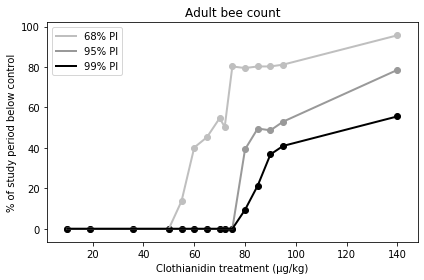

In [94]:
colors = ['0.75', '0.6', '0']
#colors = ['C0', 'C1', '0']
fig, ax = plt.subplots()
for i, pi in enumerate(pis):
    data = plot_tables[int(pi)]
    ax.plot(data['Adults'], linewidth=2, linestyle='solid', color=colors[i], label='{}% PI'.format(pi))
    ax.scatter(data['Adults'].index,data['Adults'], color=colors[i])
    #ax.axvline(x=data['Adults'][data['Adults']>0].idxmin())
ax.legend()
ax.set_title("Adult bee count")
ax.set(ylabel='% of study period below control', xlabel='Clothianidin treatment (\u03BCg/kg)')
plt.tight_layout()
#plt.savefig('figures/run3_percent_below_adults.png',dpi=600)
plt.show()

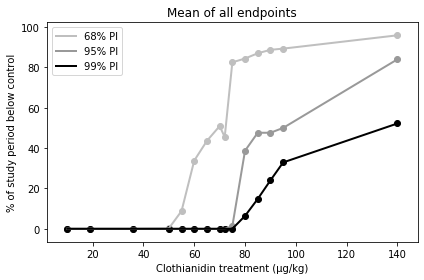

In [95]:
colors = ['0.75', '0.6', '0']
#colors = ['C0', 'C1', '0']
fig, ax = plt.subplots()
for i, pi in enumerate(pis):
    data = plot_tables[int(pi)]
    ax.plot(data['Mean'], linewidth=2, linestyle='solid', color=colors[i], label='{}% PI'.format(pi))
    ax.scatter(data['Mean'].index,data['Mean'], color=colors[i])
    #ax.axvline(x=data['Mean'][data['Mean']>0].idxmin())
ax.legend()
ax.set_title("Mean of all endpoints")
ax.set(ylabel='% of study period below control', xlabel='Clothianidin treatment (\u03BCg/kg)')
plt.tight_layout()
#plt.savefig('figures/run3_percent_below_mean.png',dpi=600)
plt.show()

#### Plot AMB-SMC analysis metrics

In [78]:
pop_data = history.get_all_populations()
pop_data['acceptance_rate'] = pop_data['particles']/pop_data['samples'] * 100
pop_data.drop(0, inplace=True)
pop_data

,t,population_end_time,samples,epsilon,particles,acceptance_rate
1,0,2020-01-09 19:26:55.883642,956,203280.893021,500,52.301255
2,1,2020-01-09 22:02:15.941485,1241,182576.456699,500,40.290089
3,2,2020-01-10 05:39:33.716929,1760,171779.356942,500,28.409091
4,3,2020-01-10 13:42:50.192482,2355,164639.237956,500,21.231423
5,4,2020-01-11 13:12:01.892261,3607,158548.883714,500,13.861935
6,5,2020-01-12 13:18:31.298848,5525,153722.399962,500,9.049774
7,6,2020-01-13 18:03:53.222173,7347,149882.621063,500,6.805499
8,7,2020-01-15 07:58:07.578950,8237,146853.478270,500,6.070171
9,8,2020-01-16 05:48:05.509282,14134,143990.751112,500,3.537569
10,9,2020-01-17 12:02:02.916984,19357,141771.233193,500,2.583045


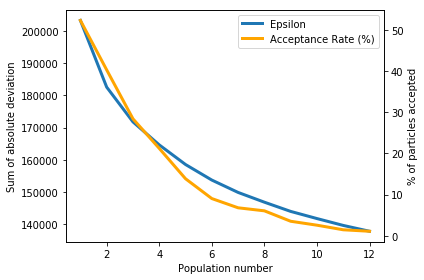

In [82]:
fig, ax = plt.subplots()
l1 = ax.plot(np.arange(1,13), pop_data['epsilon'], label='Epsilon', linewidth = 3)
#plt.legend()
ax.tick_params('vals', colors='r')
ax.set(ylabel='Sum of absolute deviation', xlabel='Population number')
ax2 = ax.twinx()
l2 = ax2.plot(np.arange(1,13), pop_data['acceptance_rate'], label='Acceptance Rate (%)', linewidth = 3, color = "orange")
ax2.set(ylabel='% of particles accepted')
lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.tight_layout()
plt.savefig('figures/run3_ABCSMC_stats.png',dpi=600)
plt.show()

In [28]:
final_pop = history.get_population_extended()

In [36]:
final_pop['w'].sum()

0.9999999999999997